In [1]:
import csv

In [2]:
import imageio
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import os
import matplotlib.pyplot as plt
%matplotlib inline

#### Model directory

In [3]:
model_dir = 'data/models/test8/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Load recorded images and steering data

In [4]:
right_camera_offset = -0.27
left_camera_offset = 0.23

In [5]:
def load_images(data_dir, discard_prob):
    df = pd.read_csv(data_dir+'driving_log.csv')
    images = []
    measurements = []

    def fetch_image(data_dir, source_path):
        filename = source_path.split('/')[-1]
        current_path = data_dir + 'IMG/' + filename
        return imageio.imread(current_path)

    def append_image(image, measurement):
        images.append(image)
        measurements.append(measurement)

        # flip image
        image_flipped = np.fliplr(image)
        measurement_flipped = -measurement
        images.append(image_flipped)
        measurements.append(measurement_flipped)

    for idx, row in df.iterrows():
        measurement = float(row[3])
        if measurement <= 0 and np.random.rand() < discard_prob:
            continue
            
        center_image = fetch_image(data_dir, row[0])
        append_image(center_image, measurement)
        
        left_image = fetch_image(data_dir, row[1])
        append_image(left_image, measurement+left_camera_offset)
        
        right_image = fetch_image(data_dir, row[2])
        append_image(right_image, measurement+right_camera_offset)
        
    return images, measurements
    
def load_from_dir(data_dir, discard_prob=0, load_cached=True):
    if load_cached and os.path.exists(data_dir+'X_train.npy'):
        X_train = np.load(data_dir+'X_train.npy')
        y_train = np.load(data_dir+'y_train.npy')
    else:
        images, measurements = load_images(data_dir, discard_prob)
        
        X_train = np.array(images)
        y_train = np.array(measurements)

        np.save(data_dir+'X_train.npy', X_train)
        np.save(data_dir+'y_train.npy', y_train)
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    return X_train, y_train
    

### Load Recorded data sets

In [6]:
# 1. sample data
X_train, y_train = load_from_dir('data/sample_data/', discard_prob=0.7)

X_train: (22218, 160, 320, 3)
y_train: (22218,)


### Create Model

In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, BatchNormalization, Input, Dropout

Using TensorFlow backend.


### NVIDIA Suggested network

In [8]:
model = Sequential()
model.add(Lambda(lambda x: x - 255.0 / 255.0, input_shape=(160,320,3)))
model.add(BatchNormalization(axis=1))
model.add(keras.layers.Convolution2D(24, (5,5), strides=(2,2), activation='relu'))
model.add(keras.layers.Convolution2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(keras.layers.Convolution2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(keras.layers.Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(keras.layers.Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

In [9]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.001))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 320, 3)       640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
batch_normalization_2 (Batch (None, 17, 37, 48)        68        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
__________

### First run

In [11]:
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)
model.save(model_dir+'nvidia_suggested_model.h5')

Train on 17774 samples, validate on 4444 samples
Epoch 1/7
17774/17774 [==============================] - 42s - loss: 0.2574 - val_loss: 0.0563
Epoch 2/7
17774/17774 [==============================] - 40s - loss: 0.0587 - val_loss: 0.0296
Epoch 3/7
17774/17774 [==============================] - 40s - loss: 0.0365 - val_loss: 0.0226
Epoch 4/7
17774/17774 [==============================] - 40s - loss: 0.0272 - val_loss: 0.0200
Epoch 5/7
17774/17774 [==============================] - 40s - loss: 0.0217 - val_loss: 0.0157
Epoch 6/7
17774/17774 [==============================] - 40s - loss: 0.0185 - val_loss: 0.0158
Epoch 7/7
17774/17774 [==============================] - 40s - loss: 0.0172 - val_loss: 0.0149


### Visualizing training loss

dict_keys(['val_loss', 'loss'])


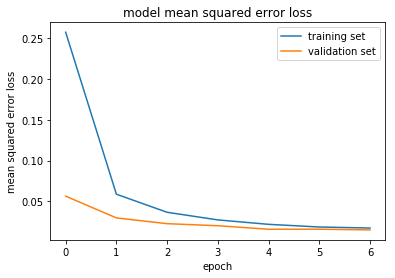

In [12]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()